# **Khushdev Pandit**
# **Roll no: 2020211** 
# *Assignment Question-2*

#

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import open3d as o3d
import glob

# **Q2 Part-1**
* ##### (10 points) Compute the chessboard plane normals nLi, i ∈ {1, . . . , 25} and the corresponding offsets di , i ∈ {1, . . . , 25} using the planar LIDAR points in each of the pcd files. You can estimate these by making use of singular value decomposition.

In [133]:
def load_camera_parameters(camera_matrix_path, distortion_coefficients_path):
    with open(distortion_coefficients_path, 'r') as f:
        contents = f.read()
        distCoeff = contents.split('\n')[:1][0].split(' ')
        distCoeff = np.array(distCoeff, dtype=np.float32)
    return load_matrix(camera_matrix_path), distCoeff


def load_matrix(file_path):
    with open(file_path, 'r') as f:
        contents = f.read()
        matrix = contents.split('\n')[:3]
        matrix = [i.split(' ') for i in matrix]
        matrix = np.array(matrix, dtype=np.float32)
    return matrix


def load_vector(file_path):
    with open(file_path, 'r') as f:
        contents = f.read()
        vector = contents.split('\n')[:3]
        vector = np.array(vector, dtype=np.float32)
    return vector


def load_camera_coord_param_for_image(folder_path):
    camera_normal = load_vector(os.path.join(folder_path, 'camera_normals.txt'))
    rotation_matrix = load_matrix(os.path.join(folder_path, 'rotation_matrix.txt'))
    rotation_vector = load_vector(os.path.join(folder_path, 'rotation_vectors.txt'))
    translation_vector = load_vector(os.path.join(folder_path, 'translation_vectors.txt'))
    return camera_normal, rotation_matrix, rotation_vector, translation_vector

In [134]:
lidar_scans = glob.glob('lidar_scans/*.pcd')
camera_images = glob.glob('camera_images/*.jpeg')
camera_coord_param = glob.glob('camera_parameters/*.jpeg')
camera_param = glob.glob('camera_parameters/*.txt')
indices = np.arange(0, len(lidar_scans))
indices = np.random.choice(indices, 25, replace=False)

camera_images = np.array(camera_images)[indices]
lidar_scans = np.array(lidar_scans)[indices]
camera_coord_param = np.array(camera_coord_param)[indices]

In [141]:
lidar_plane_normals = []
lidar_plane_offsets = []

for lidar in lidar_scans:
    pcd = o3d.io.read_point_cloud(lidar)
    plane_model, inliers = pcd.segment_plane(distance_threshold=0.01,
                                             ransac_n=3,
                                             num_iterations=1000)
    normal = plane_model[:3]
    offset = plane_model[3]
    lidar_plane_normals.append(normal)
    lidar_plane_offsets.append(offset)
lidar_plane_normals, lidar_plane_offsets = np.array(lidar_plane_normals), np.array(lidar_plane_offsets)

In [121]:
lidar_plane_normals = []
lidar_plane_offsets = []

for lidar in lidar_scans:
    pcd = o3d.io.read_point_cloud(lidar)
    # Estimate plane model coefficients using RANSAC algorithm
    plane_model, inliers = pcd.segment_plane(distance_threshold=0.01,
                                            ransac_n=3,
                                            num_iterations=1000)

    # Extract inlier points
    points = np.asarray(pcd.points)
    # Compute centroid of the planar points
    centroid = np.mean(points, axis=0)
    # Subtract centroid from the points
    centered_points = points - centroid
    # Perform SVD on the centered points
    U, S, V = np.linalg.svd(centered_points)
    # Estimate plane normal
    normal = V[-1, :]  # Last row of vh matrix
    # Estimate offset of the plane
    offset = np.dot(normal, centroid)
    lidar_plane_normals.append(normal)
    lidar_plane_offsets.append(offset)

lidar_plane_normals, lidar_plane_offsets = np.array(lidar_plane_normals), np.array(lidar_plane_offsets)

In [122]:
res = lidar_plane_normals_open3d - lidar_plane_normals
res.mean(), res.std()

(0.14213223440461228, 0.7872569865074627)

# **Q2 Part-2**
* ##### (10 points) Now that you have the plane normals nCi and nLi in camera and LIDAR frame of reference respectively for all the selected images, derive the set of equations that you would use to solve for estimating the transformation CTL = [CRL|CtL], i.e. the transformation from the LIDAR frame to the camera frame. Explain how the rotation and translation matrices are calculated. [Hint: You may refer to this thesis (Sec. 5) for deriving the necessary equations.]

In [136]:
np.linalg.norm(lidar_plane_normals, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

# **Q2 Part-3**
* ##### (5 points) Using the above equations, implement the function that estimates the transformation CTL. Recall that the rotation matrix has determinant +1.

In [142]:
camera_plane_normals = []
camera_plane_offsets = []

for image in camera_coord_param:
    # camera_normal, rotation_matrix, rotation_vector, translation_vector
    nCi, RCi, rCi, tCi = load_camera_coord_param_for_image(image)
    
    # Extract orientation (θc,i) and distance (αc,i)
    # Orientation (θc,i)
    # orientation_ci = np.dot(RCi, nCi)  / np.linalg.norm(nCi)
    orientation_ci = nCi
    
    # Distance (αc,i)
    alpha_ci = np.dot(rCi, tCi) / np.linalg.norm(nCi) 

    camera_plane_normals.append(orientation_ci)
    camera_plane_offsets.append(alpha_ci)

camera_plane_normals = np.array(camera_plane_normals)
camera_plane_offsets = np.array(camera_plane_offsets)

In [143]:
lidar_plane_normals.shape, camera_plane_normals.shape

((25, 3), (25, 3))

In [126]:
def get_lidar_to_camera_transform(lidar_plane_normals, lidar_plane_offsets, 
                                camera_plane_normals, camera_plane_offsets):
    mat1 = np.linalg.inv(np.dot(camera_plane_normals.T, camera_plane_normals))
    mat2 = np.dot(camera_plane_normals.T, (camera_plane_offsets - lidar_plane_offsets))
    
    # Translation vector (t)
    CtL = np.dot(mat1, mat2)
    
    # U, S, V = np.linalg.svd(np.dot(lidar_plane_normals, camera_plane_normals))
    U, S, V = np.linalg.svd(np.dot(lidar_plane_normals.T, camera_plane_normals))
    
    # Rotation matrix (R)
    CRL = np.dot(U, V)
    
    # Transform matrix from lidar to camera
    CTL = np.hstack((CRL, CtL.reshape(3, 1)))
    return CTL, CRL, CtL

CTL, CRL, CtL = get_lidar_to_camera_transform(lidar_plane_normals, lidar_plane_offsets, camera_plane_normals, camera_plane_offsets)
print(CTL)

[[-0.09035055  0.70481201  0.70361694  2.79617303]
 [-0.9839297   0.04608353 -0.17250696 -1.59732979]
 [ 0.15401012  0.70789571 -0.6893218  -7.69876846]]


In [127]:
np.linalg.det(CRL)

-1.0000000000000013

# **Q2 Part-4**
* ##### (5 points) Use the estimated transformation CTe L to map LIDAR points to the camera frame of reference, then project them to the image plane using the intrinsic camera parameters. Are all points within the checkerboard pattern’s boundary in each image?

In [128]:
intrinsic_matrix, distCoeff = load_camera_parameters(*camera_param)
camera_intrinsic = np.hstack((intrinsic_matrix, np.zeros((3, 1))))
camera_extrinsic = np.vstack((CTL, np.array([0, 0, 0, 1])))
camera_projection_matrix = np.dot(camera_intrinsic, camera_extrinsic)

In [129]:
camera_image_points = []
for lidar in lidar_scans:
    pcd = o3d.io.read_point_cloud(lidar)
    plane_model, inliers = pcd.segment_plane(distance_threshold=0.01,
                                            ransac_n=3,
                                            num_iterations=1000)
    lidar_points = np.asarray(pcd.points)
    lidar_points = np.vstack((lidar_points.T, np.ones((1, len(lidar_points))) ))
    camera_points = np.dot(camera_projection_matrix, lidar_points)
    camera_points = camera_points[:2, :] / camera_points[2, :]
    camera_image_points.append(camera_points)

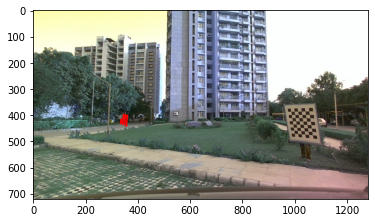

In [130]:
for i, image in enumerate(camera_images):
    image = cv2.imread(image)
    
    image_points_x = camera_image_points[i][0, :]/2 #* image.shape[0]
    image_points_y = camera_image_points[i][1, :]/2 #* image.shape[1]
    
    for i in range(image_points_x.shape[0]):
        cv2.circle(img=image, center=(int(image_points_x[i]), int(image_points_y[i])), 
                   radius=1, color=(255, 0, 0), thickness=3) 

    plt.imshow(image)
    plt.show()
    break

# **Q2 Part-5**
* ##### (10 points) Plot the normal vectors nL_i, nC_i, CRL_nL_i for any 5 image and LIDAR scan pairs. Compute the cosine distance between the camera normal nCi and the transformed LIDAR normal, CRL_nL_i for all 38 image and LIDAR scan pairs, and plot the histogram of these errors. Report the average error with the standard deviation.

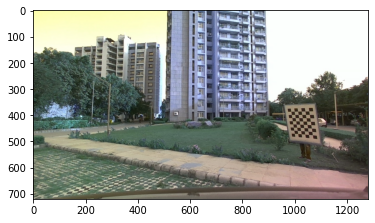

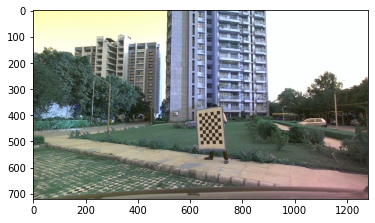

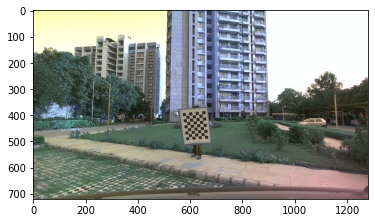

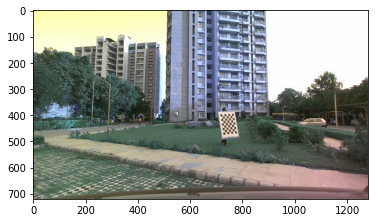

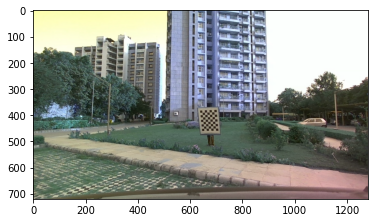

In [131]:
for image in camera_images[:5]:
    image = cv2.imread(image)
    plt.imshow(image)
    plt.show()